In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import wandb
api = wandb.Api()

sns.set_style(style='whitegrid')

In [2]:
models = ['Transformer', 'N-BEATS', 'GRU', 'LSTM']
tasks = ['none', 'featurization', 'classification', 'forecasting']

markers = dict(zip(tasks, [',', 'X', 'o', '>']))

In [3]:
def plot(
    ylabel: str,
    ylogscale: bool = False,
    rolling_window: int = 200,
    markevery=0.1,
    fig_name=None,
    fig_size=(8, 4),
    xticks_every=3,
    xticks_minor=None,
    markersize=10,
    linewidth=0.8,
    dashes=False,
    ylim=None,
    **kwargs
):
    fgrid = sns.lineplot(
        markevery=markevery,
        markersize=markersize,
        palette='colorblind',
        linewidth=linewidth,
        dashes=dashes,
        **kwargs
    )
    fgrid.figure.set_size_inches(fig_size)
    fgrid.xaxis.set_major_locator(MultipleLocator(xticks_every))
    if xticks_minor is None:
        xticks_minor = xticks_every
    fgrid.xaxis.set_minor_locator(AutoMinorLocator(xticks_minor))
    
    fgrid.grid(which='major', color='#CCCCCC', linestyle='--')
    fgrid.grid(which='minor', color='#CCCCCC', linestyle=':')
    fgrid.set(ylabel=ylabel)
    if fig_name is not None:
        fgrid.get_figure().savefig(fig_name, format='pdf')
    if ylogscale:
        fgrid.set(yscale='log')
    if ylim is not None:
        fgrid.set(ylim=ylim)
    return fgrid

# Getting data directly from wandb's api

In [30]:
def process_project(project: str, rolling_window: int = 200, ignore=None):
    runs = api.runs(project)
    l = []
    for run in runs:
        if ignore is not None and ignore in run.name:
            print(f'ignored {run.name}')
            continue
        print(run.name)
        df = run.history(samples=None)
        df['epoch'] = df['_step'] / df['_step'].max() * (df['epoch'].max() + 1)
        value_cols = [x for x in df.columns if x.endswith('.train') or x.endswith('.val') or x.endswith('.test')]
        df = df[['epoch'] + value_cols]
        df = df[~df[value_cols].isnull().all(axis=1)]
        for col in value_cols:
            df[col] = df[col].rolling(rolling_window, min_periods=1).mean().values
        df['run'] = run.name.replace('_None_', '_')
        l.append(df)
    df = pd.concat(l)
    df = df.reset_index(drop=True)
    return df

In [6]:
def plots_per_model(data: pd.DataFrame, 
                    ylogscale: bool = False, 
                    legend_pos: int = 1, 
                    markers=markers, 
                    sharex=True,
                    sharey=True,
                    fig_size=(10, 7),
                    ncol=2,
                    **kwargs):
    fig, axes = plt.subplots(2, 2, sharex=sharex, sharey=sharey)
    for i, model in enumerate(models):
        curr_ax = axes[i // 2, i % 2]
        plot(
            data=data[data.model == model],
            x='epoch',
            markers=markers,
            legend=(i==legend_pos),
            ax=curr_ax,
            fig_size=fig_size,
            **kwargs
        )
        if ylogscale and not sharey:
            curr_ax.set_yscale('log')
        curr_ax.title.set_text(model)
    
    legend_ax = axes[legend_pos // 2, legend_pos % 2]
    if ncol != 1:
        handles, labels = legend_ax.get_legend_handles_labels()
        legend_ax.legend(handles=handles, labels=labels, ncol=ncol)
    fig.set_tight_layout(True)
    if ylogscale and sharey:
        axes[0, 0].set_yscale('log')
    return fig, axes

def accuracy_plots_per_model(y=None, **kwargs):
    return plots_per_model(ylim=(0, 1), y=y or 'acc.train', ylabel='Classification accuracy', **kwargs)

def cross_loss_plots_per_model(y=None, **kwargs):
    return plots_per_model(ylogscale=True, y=y or 'loss.cross.train', ylabel='Cross-entropy loss', **kwargs)

def mse_loss_plots_per_model(y=None, **kwargs):
    return plots_per_model(ylogscale=True, y=y or 'loss.mse.train', ylabel='MSE loss', **kwargs)

## Feature Freeze

In [6]:
df = process_project('streitlua/feature-freeze')
df['tasks'] = df['run'].apply(lambda x: x[x.find('_')+1:])
df['pre-training task'] = df['tasks'].apply(lambda x: x.split('>')[0] if len(x.split('>')) > 1 else 'none')
df['task'] = df['tasks'].apply(lambda x: x.split('>')[-1])
df['model'] = df['run'].apply(lambda x: x.split('_')[0])
df.drop(columns=['run', 'tasks'], inplace=True)

In [12]:
def pre_task_loss_plots_per_model(df: pd.DataFrame, task: str, **kwargs):
    plot_f = {
        'classification': cross_loss_plots_per_model,
        'forecasting': mse_loss_plots_per_model
    }
    return plot_f[task](
        data=df[df.task == task],
        style='pre-training task',
        style_order=list(filter(lambda s: s != task, tasks)),
        ncol=1,
        **kwargs
    )

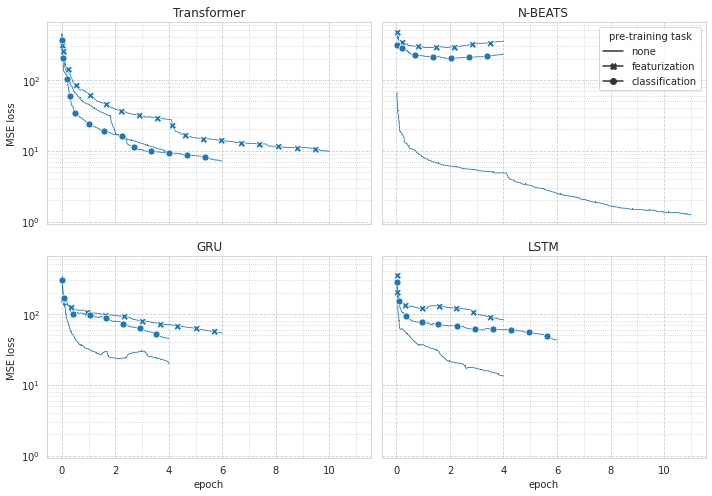

In [8]:
fig, axes = pre_task_loss_plots_per_model(df, task='forecasting', xticks_every=2, markersize=7, markevery=0.05)
fig.savefig('../../Resources/ICML SCIS Paper/forecasting-loss.pdf', format='pdf');

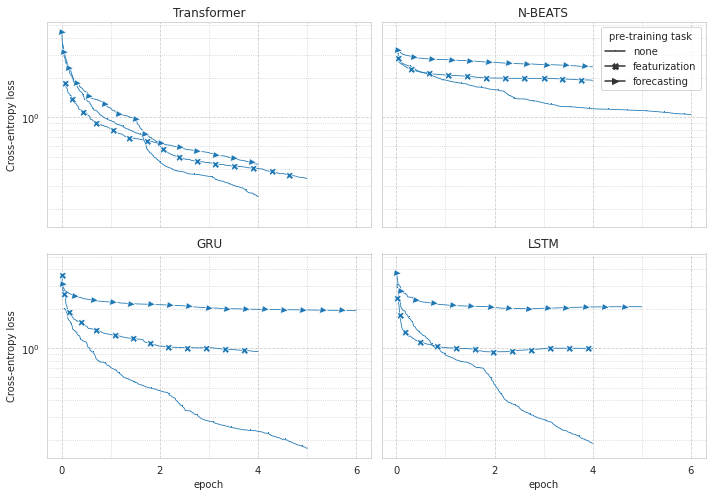

In [9]:
fig, axes = pre_task_loss_plots_per_model(df, task='classification', xticks_every=2, markersize=7, markevery=0.05)
fig.savefig('../../Resources/ICML SCIS Paper/classification-loss.pdf', format='pdf');

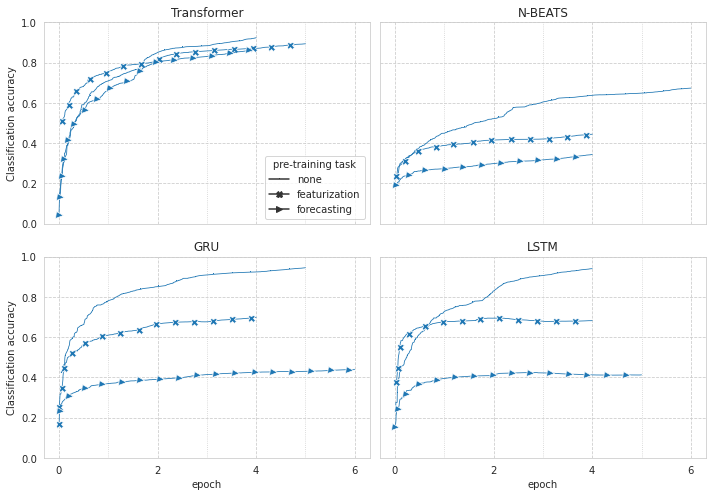

In [10]:
fig, axes = accuracy_plots_per_model(
    data=df,
    style='pre-training task',
    style_order=list(filter(lambda s: s != 'classification', tasks)),
    xticks_every=2,
    legend_pos=0,
    markersize=7,
    markevery=0.05,
    ncol=1,
)
fig.savefig('../../Resources/ICML SCIS Paper/classification-accuracy.pdf', format='pdf');

## Splits

In [11]:
df = process_project('streitlua/classification-of-attractors', rolling_window=100)
df['model'] = df['run'].apply(lambda x: x.split('_')[0])
df['split'] = df['run'].apply(lambda x: x.split('split_')[1])
df['task'] = 'classification'
df.columns = [col.replace('loss', 'loss.cross') for col in df.columns]
df.drop(columns=['run'], inplace=True)

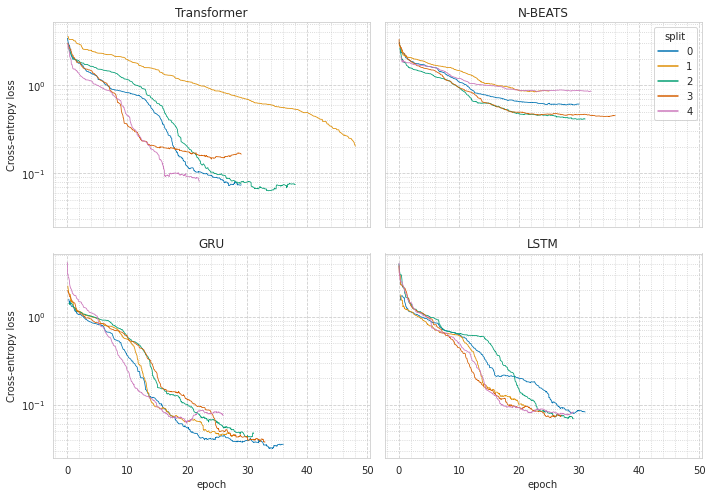

In [12]:
fig, axes = cross_loss_plots_per_model(
    data=df,
    xticks_every=10,
    xticks_minor=5,
    hue='split',
    hue_order=list(map(lambda i: str(i), range(5))),
    ncol=1,
)
fig.savefig('../../Resources/ICML SCIS Paper/split-classification-loss.pdf', format='pdf');

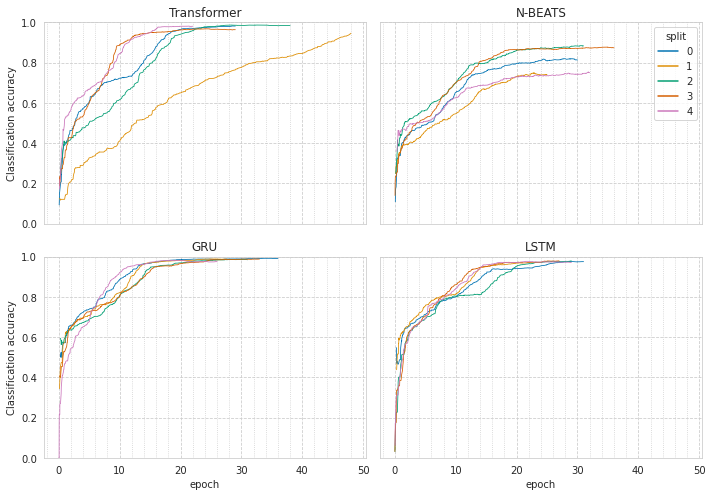

In [13]:
fig, axes = accuracy_plots_per_model(
    data=df,
    xticks_every=10,
    xticks_minor=5,
    hue='split',
    hue_order=list(map(lambda i: str(i), range(5))),
    ncol=1,
)
fig.savefig('../../Resources/ICML SCIS Paper/split-classification-accuracy.pdf', format='pdf');

## Few Shot (Sprott)

In [19]:
df = process_project('streitlua/few-shot-sprott', rolling_window=20, ignore='before')
df['model'] = df['run'].apply(lambda x: x.split('_')[0])
df['task'] = df['run'].apply(lambda x: x.split('_')[1])
df['attractors'] = df['run'].apply(lambda x: x.split('_')[2]).replace({'related': 'similar', 'unrelated': 'different'})
df['pre-training'] = df['run'].apply(lambda x: x.split('_')[3]).replace({'after': 'yes', 'lone': 'no'})
df.drop(columns=['run'], inplace=True)
df

,epoch,SprottE.feature.std.train,loss.triplet.train,SprottE.feature.std.val,SprottE.feature.std.test,loss.triplet.val,loss.triplet.test,SprottE.loss.mse.train,loss.mse.train,loss.mse.test,...,acc.test,loss.cross.val,SprottE.sensitivity.val,loss.cross.test,SprottE.specificity.val,SprottE.specificity.test,model,task,attractors,pre-training
0,0.017878,0.203171,0.236009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LSTM,featurization,similar,yes
1,0.071514,0.243850,0.203569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LSTM,featurization,similar,yes
2,0.080453,0.261037,0.190471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LSTM,featurization,similar,yes
3,0.107271,0.261037,0.190471,0.323467,0.324811,0.125573,0.123374,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LSTM,featurization,similar,yes
4,0.134088,0.277942,0.170513,0.323467,0.324811,0.125573,0.123374,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LSTM,featurization,similar,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23250,14.774504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.759947,1.493938,0.656455,1.510499,0.998481,0.997257,N-BEATS,classification,similar,no
23251,14.918821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.759947,1.493938,0.656455,1.510499,0.998481,0.997257,N-BEATS,classification,similar,no
23252,14.945881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.759947,1.493938,0.656455,1.510499,0.998481,0.997257,N-BEATS,classification,similar,no
23253,14.954901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.634947,2.568548,0.333284,2.571767,1.000000,1.000000,N-BEATS,classification,similar,no


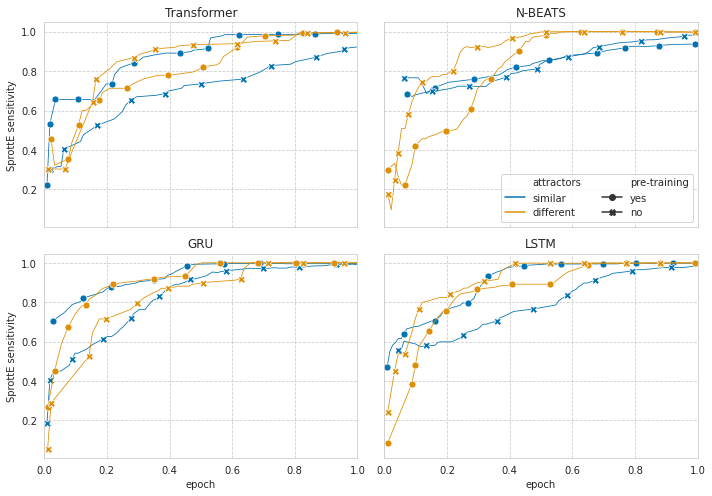

In [20]:
fig, axes = plots_per_model(
    data=df,
    y='SprottE.sensitivity.train',
    ylogscale=False,
    ylabel='SprottE sensitivity',
    sharex=True,
    sharey=True,
    xticks_every=0.2,
    hue='attractors',
    style='pre-training',
    markers=True,
    markersize=7,
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/ICML SCIS Paper/sprott-sensitivity.pdf', format='pdf');

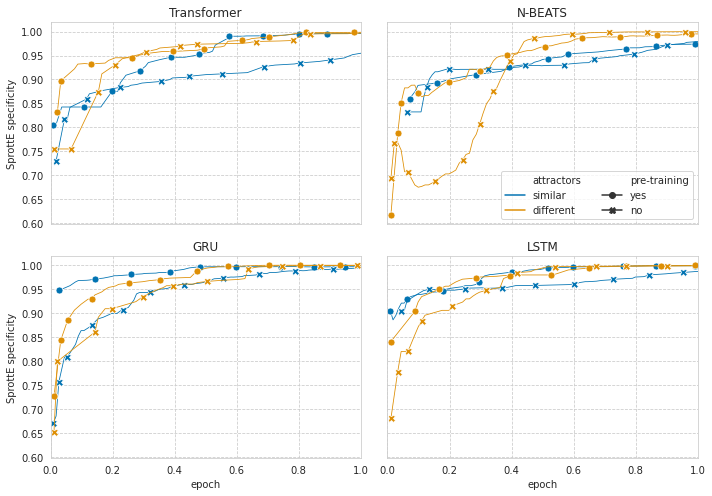

In [21]:
fig, axes = plots_per_model(
    data=df,
    y='SprottE.specificity.train',
    ylogscale=False,
    ylabel='SprottE specificity',
    sharex=True,
    sharey=True,
    xticks_every=0.2,
    hue='attractors',
    style='pre-training',
    markers=True,
    markersize=7,
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/ICML SCIS Paper/sprott-specificity.pdf', format='pdf');

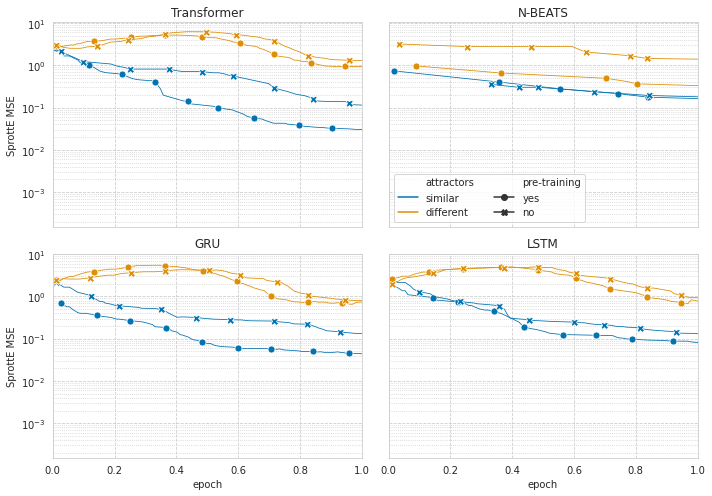

In [22]:
fig, axes = plots_per_model(
    data=df,
    y='SprottE.loss.mse.train',
    ylogscale=True,
    ylabel='SprottE MSE',
    sharex=True,
    sharey=True,
    xticks_every=0.2,
    hue='attractors',
    style='pre-training',
    markers=True,
    markersize=7,
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/ICML SCIS Paper/sprott-mse.pdf', format='pdf');

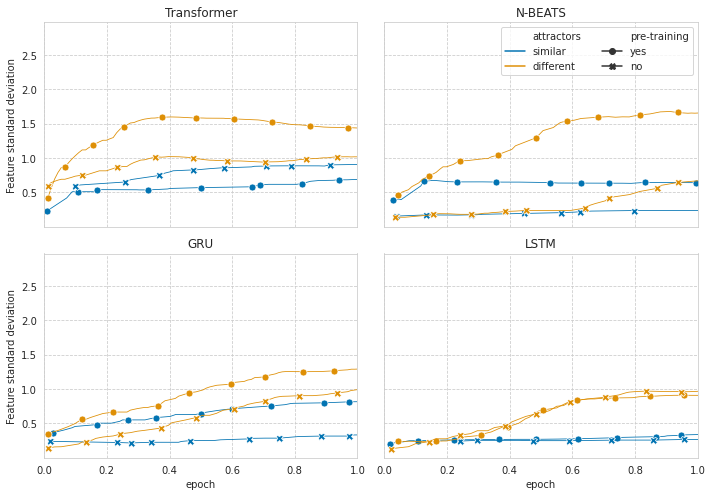

In [18]:
fig, axes = plots_per_model(
    data=df,
    y='SprottE.feature.std.train',
    ylogscale=False,
    ylabel='Feature standard deviation',
    sharex=True,
    sharey=True,
    xticks_every=0.2,
    hue='attractors',
    style='pre-training',
    markers=True,
    markersize=7,
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/ICML SCIS Paper/sprott-feature-std.pdf', format='pdf');

## Prober

In [31]:
df = process_project('streitlua/prober')
df['model'] = df['run'].apply(lambda x: x.split('_')[0])
df['tasks'] = df['run'].apply(lambda x: x[x.index('_')+1:])
df['pre-training task'] = df['tasks'].apply(lambda x: x.split('_then_')[0] if '_then_' in x else 'none')
df['task'] = df['tasks'].apply(lambda x: x.split('_')[-1])
df

GRU_forecasting_then_classification
GRU_forecasting_then_featurization
GRU_forecasting
Transformer_forecasting_then_classification
LSTM_classification_then_forecasting
LSTM_classification_then_featurization
LSTM_classification
GRU_classification_then_forecasting
GRU_classification_then_featurization
GRU_classification
Transformer_classification_then_forecasting
Transformer_forecasting_then_featurization
Transformer_forecasting
N-BEATS_forecasting_then_classification
Transformer_classification_then_featurization
Transformer_classification
N-BEATS_forecasting_then_featurization
N-BEATS_classification_then_forecasting
N-BEATS_classification_then_featurization
N-BEATS_forecasting
N-BEATS_classification


,epoch,acc.train,loss.mse.train,loss.cross.train,run,loss.mse.test,loss.triplet.val,loss.mse.val,loss.triplet.test,loss.triplet.train,acc.val,acc.test,loss.cross.val,loss.cross.test,model,tasks,pre-training task,task
0,0.200000,0.006836,16.010548,4.776609,GRU_forecasting_then_classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRU,forecasting_then_classification,forecasting,classification
1,0.400000,0.019043,15.551126,4.647261,GRU_forecasting_then_classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRU,forecasting_then_classification,forecasting,classification
2,0.600000,0.032552,16.866109,4.553067,GRU_forecasting_then_classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRU,forecasting_then_classification,forecasting,classification
3,0.800000,0.041992,17.511611,4.467191,GRU_forecasting_then_classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRU,forecasting_then_classification,forecasting,classification
4,1.000000,0.053125,19.787650,4.387066,GRU_forecasting_then_classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRU,forecasting_then_classification,forecasting,classification
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,5.979754,0.618549,NaN,1.219444,N-BEATS_classification,NaN,0.520623,NaN,0.520705,0.519295,0.091547,0.090422,8.198365,8.268329,N-BEATS,classification,none,classification
9999,5.980204,0.618839,NaN,1.218787,N-BEATS_classification,NaN,0.520623,NaN,0.520705,0.519211,0.091547,0.090422,8.198365,8.268329,N-BEATS,classification,none,classification
10000,5.992801,0.619542,NaN,1.216880,N-BEATS_classification,NaN,0.520623,NaN,0.520705,0.519422,0.091547,0.090422,8.198365,8.268329,N-BEATS,classification,none,classification
10001,5.996401,0.619353,NaN,1.216836,N-BEATS_classification,NaN,0.520623,NaN,0.520705,0.519466,0.091547,0.090422,8.198365,8.268329,N-BEATS,classification,none,classification


In [32]:
df[(df.task == 'classification') & ~df['loss.mse.train'].isna()].model.unique()

array(['GRU', 'Transformer', 'N-BEATS'], dtype=object)

In [23]:
df.groupby(['task', 'model']).count()['loss.mse.train']

task            model      
classification  GRU               5
                LSTM              0
                N-BEATS         506
                Transformer     511
featurization   GRU             487
                LSTM              0
                N-BEATS         500
                Transformer     487
forecasting     GRU            1035
                LSTM            489
                N-BEATS        1011
                Transformer    1036
Name: loss.mse.train, dtype: int64

In [36]:
df.groupby(['task', 'model']).distinct()

AttributeError: 'DataFrameGroupBy' object has no attribute 'distinct'

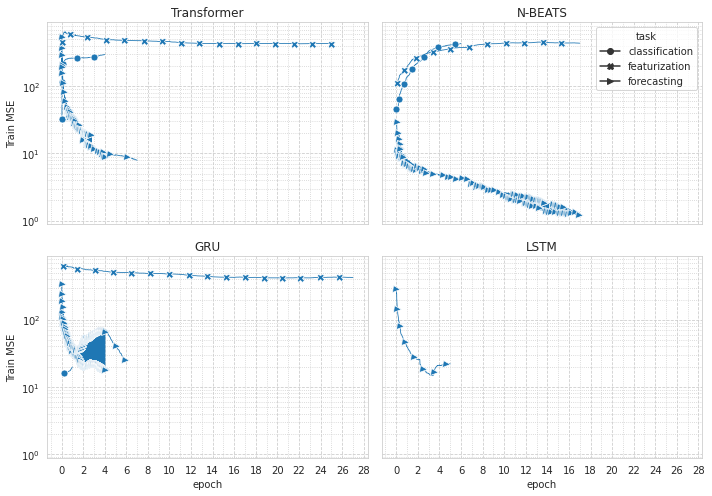

In [18]:
plots_per_model(
    data=df,
    y='loss.mse.train',
    style='task',
    ylogscale=True,
    ylabel='Train MSE',
    sharex=True,
    sharey=True,
    xticks_every=2,
    markersize=7,
    markevery=0.05,
    ncol=1,
);